## Scraping

In [100]:
#import crawling libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np

#####!!======= Don't run this, just download the 'indeed_ca_vf.csv' and import it=======!!#####
#####!!======= If you try to run this, Indeed will block ur IP over 350 requests =======!!#####

#designate the address to scrape data
address = 'https://ca.indeed.com/jobs?q=data&l=Canada&filter=0&start='
api_url = "https://ca.indeed.com/viewjob?viewtype=embedded&jk={job_id}"

#create lists to store retrieved data
index = []
jobtitle = []
company = []
jobdesc = []

#build loops for page numbers to scrap and store the data
#one page has 15 posts
for i in range (500):
    url = address + str(i*10)
    soup = BeautifulSoup(requests.get(url).content, "html.parser")

    for job in soup.select('a[id^="job_"]'):
        job_id = job["id"].split("_")[-1]
        s = BeautifulSoup(
            requests.get(api_url.format(job_id=job_id), headers=headers).content,
            "html.parser",
        )
  
        company_title = s.find("meta", property="og:description")
        job_desc = s.select_one("#jobDescriptionText")
        
        index.append(i+1)
        jobtitle.append(s.title.get_text(strip=True))
        company.append(company_title["content"] if company_title else np.nan)
        jobdesc.append(job_desc.get_text(strip=True) if job_desc else np.nan)
        
        ##print the data to check whether it works
        print(s.title.get_text(strip=True))
        #print()
        #print(s.select_one("#jobDescriptionText").get_text(strip=True, separator="\n"))
        #print("#" * 80)

#encapsulate lists into dataframe
final_dict = {'index': index, 'job_title':jobtitle, 'company':company, 'job_desc':jobdesc}
df = pd.DataFrame(final_dict)

#drop the redundant posts
df.drop_duplicates().reset_index()

#export the dataframe as csv file
df.to_csv("indeed_ca_vf.csv")

In [101]:
from pathlib import Path
path = Path.cwd() # current working directory

In [102]:
df = pd.read_csv("indeed_ca_vf.csv", index_col = 0)
df 

,index,job_title,company,job_desc
0,0,"Data Analyst - Montréal, QC - Indeed.com",Ubisoft,Company DescriptionCreating the unknown since ...
1,1,"Data Entry/Document Processor - Saskatoon, SK ...",Government of Saskatchewan,Data Entry/Document Processor-ADM019915Employm...
2,2,"TV Listings Data Entry - Orleans, ON - Indeed.com",TV Media Inc.,ResponsibilitiesEdit and maintain a database o...
3,3,Data Analyst Co-op (remote optional) - Vancouv...,Spare Labs,Spare is growing and we are looking for aData ...
4,4,Data & Applied Sciences: Intern Opportunities ...,Microsoft,"Every year, we welcome thousands of university..."
...,...,...,...,...
1238,4701,"Amazon Business Analyst - Mont-royal, QC - Ind...",Earth Rated,IntroductionEarth Rated is a small but growing...
1239,4893,"Student Intern - Marketing & Sales Analyst, Da...",TMX Group Limited,The Summer Associate position will be responsi...
1240,5115,"Database Support Specialist - Squamish, BC - I...",Sea to Sky Community Services,Part-time permanent position - 28 hours per we...
1241,5124,"Senior Data Engineer - Halifax, NS - Indeed.com",MobSquad,"ABOUT MOBSQUADWe are a well-funded, hyper-grow..."


In [103]:
## sample job description 
df.loc[0, 'job_desc']

'Company DescriptionCreating the unknown since 1997.When you join Ubi MTL, you’ll discover a workplace that sparks inspiration and connection: an environment with a variety of voices, identities, backgrounds, experiences, and perspectives. We offer a collaborative space that provides career advancement, a host of learning opportunities, and meaningful benefits centred on well-being. Our shared desire to dream big, take risks, and constantly improve contributes to the innovation and boundary-pushing that ultimately leads to our collective success. Join us!Job DescriptionAt Ubisoft IT, Customer & Marketing Solutions ("C&MS") is creating and maintaining Marketing tools and products. We are leveraging cloud, data and business intelligence to help marketing teams in their decision-making. These products are CRM & Media, Customer Service, Digital Marketing, Brand Management, Community management and E-sports. They allow marketing teams to better engage with the players across their Ubisoft J

In [104]:
post_text = df['job_desc'].astype(str).to_list()

## Tokenize/remove stopwords/lemmatize

In [105]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

In [106]:
def tokenizer(words) -> list:
    tokenizer = RegexpTokenizer(r'[\w-]+')
    tokens = tokenizer.tokenize(words.lower())

    stopwords_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    return [lemmatizer.lemmatize(token, pos='v') for token in tokens if token not in stopwords_set]

#apply tokenizer function to each post, using set to remove the repeat and store in processed text
processed_text = []
for comment in post_text:
    processed_text.append(list(set(tokenizer(comment))))

In [107]:
df['processed_desc'] = processed_text

In [108]:
df

,index,job_title,company,job_desc,processed_desc
0,0,"Data Analyst - Montréal, QC - Indeed.com",Ubisoft,Company DescriptionCreating the unknown since ...,"[spark, inspiration, better, form, leverage, i..."
1,1,"Data Entry/Document Processor - Saskatoon, SK ...",Government of Saskatchewan,Data Entry/Document Processor-ADM019915Employm...,"[assist, form, submit, identify, full-timeloca..."
2,2,"TV Listings Data Entry - Orleans, ON - Indeed.com",TV Media Inc.,ResponsibilitiesEdit and maintain a database o...,"[various, database, deadlinesstrong, establish..."
3,3,Data Analyst Co-op (remote optional) - Vancouv...,Spare Labs,Spare is growing and we are looking for aData ...,"[status, complete, kepler, disability, program..."
4,4,Data & Applied Sciences: Intern Opportunities ...,Microsoft,"Every year, we welcome thousands of university...","[sciences, area, techniques, excellence, conti..."
...,...,...,...,...,...
1238,4701,"Amazon Business Analyst - Mont-royal, QC - Ind...",Earth Rated,IntroductionEarth Rated is a small but growing...,"[chore, evolution, value, identification, assi..."
1239,4893,"Student Intern - Marketing & Sales Analyst, Da...",TMX Group Limited,The Summer Associate position will be responsi...,"[techniques, findingsattention, assist, databa..."
1240,5115,"Database Support Specialist - Squamish, BC - I...",Sea to Sky Community Services,Part-time permanent position - 28 hours per we...,"[equivalent, database, assist, combination, ca..."
1241,5124,"Senior Data Engineer - Halifax, NS - Indeed.com",MobSquad,"ABOUT MOBSQUADWe are a well-funded, hyper-grow...","[integral, server, spark, permanent, key, give..."


In [109]:
## Figure out the most frequent words appear in job descriptions
from collections import Counter
total_counts = Counter()

for i in range(len(processed_text)):
    for word in processed_text[i]:
        total_counts[word]+=1

In [110]:
df_freq = pd.DataFrame.from_dict(total_counts, orient='index', columns = ['frequency'])
df_freq.sort_values(by = 'frequency', ascending = False).head(10)

,frequency
data,1204
work,1153
experience,1114
team,1058
business,920
skills,892
process,883
support,871
include,849
provide,836


## Analyze the relavent skills frequency in all posts

### Import the skillset sheet

In [111]:
skills = pd.read_excel("skillsets.xlsx")
skills = skills[['softskills','tecchnical','quantitative','Degree']]

In [112]:
skills.head(3)

,softskills,tecchnical,quantitative,Degree
0,Business Requirements,debug,Modeling,Computer Science
1,Capital management,test,Analytics,Statistics
2,Collaboration,Programming,SQL,Data Science


In [113]:
## change all the content to lower case
skills['softskills']=skills['softskills'].str.lower()
skills['tecchnical']=skills['tecchnical'].str.lower()
skills['quantitative']=skills['quantitative'].str.lower()
skills['Degree']=skills['Degree'].str.lower()

In [114]:
skills.head(3)

,softskills,tecchnical,quantitative,Degree
0,business requirements,debug,modeling,computer science
1,capital management,test,analytics,statistics
2,collaboration,programming,sql,data science


## Analyze the relation between different data related job and the skills they required

### Tagging job post to 3 different position: data analyst, business analyst and data scientist

In [115]:
job_title_text = df['job_title'].astype(str).to_list()

In [116]:
job_title_str = []
for i in range(len(job_title_text)):
    job_title_str.append(job_title_text[i].lower().split())

In [117]:
## Find data analyst related job
## which means the job title contains both data and analyst
data_analyst_desc = []
for i in range(len(job_title_str)):
    if 'data'in job_title_str[i] and 'analyst' in job_title_str[i]:
        data_analyst_desc.append(processed_text[i])

In [118]:
da_post_count = len(data_analyst_desc) ##this also represent the frequency of data analyst in all the posts

In [119]:
## Find data scientist related job
## which means the job title contains both data and analyst
data_scientist_desc = []
for i in range(len(job_title_str)):
    if 'data'in job_title_str[i] and 'scientist' in job_title_str[i]:
        data_scientist_desc.append(processed_text[i])

In [120]:
ds_post_count = len(data_scientist_desc)

In [121]:
## Find business analyst related job
## which means the job title contains both data and analyst
business_analyst_desc = []
for i in range(len(job_title_str)):
    if 'business'in job_title_str[i] and 'analyst' in job_title_str[i]:
        #print(job_title_str[i])
        business_analyst_desc.append(processed_text[i])

In [122]:
ba_post_count= len(business_analyst_desc)

In [123]:
total_post_count = len(processed_text)

### Calculate the lift value for (job,skill) pair

We want to further examine the relationship between four types of skills and three different job.
First we calculate the frequency of four skill categories. To do so, we replace detail skills with the general category and count the time each skill category appeared in text.

In [124]:
import copy
copy_post = copy.deepcopy(processed_text)

In [125]:
#to replace each specific attribute words with attributes categories in the text

for j in range(len(copy_post)):
    for i in range(len(copy_post[j])):
        if copy_post[j][i] in skills.softskills.dropna().tolist():
            copy_post[j][i] = 'softskills'
            continue
        if copy_post[j][i] in skills.tecchnical.dropna().tolist():
            copy_post[j][i] = 'tecchnical_skill'
            continue
        if copy_post[j][i] in skills.quantitative.dropna().tolist():
            copy_post[j][i] = 'quantitative_skill'
            continue
        if copy_post[j][i] in skills.Degree.dropna().tolist():
            copy_post[j][i] = 'degree'

In [126]:
## Calculate frequency
softskill_fre = 0
for  desc in copy_post:
    target = ' '.join(desc).lower()
    if 'softskills' in target:
        softskill_fre += 1

techkill_fre = 0
for  desc in copy_post:
    target = ' '.join(desc).lower()
    if 'tecchnical_skill' in target:
        techkill_fre += 1
        
quantkill_fre = 0
for  desc in copy_post:
    target = ' '.join(desc).lower()
    if 'quantitative_skill' in target:
        quantkill_fre += 1
        
degree_fre = 0
for  desc in copy_post:
    target = ' '.join(desc).lower()
    if 'degree' in target:
        degree_fre += 1

In [127]:
skill_fre = [softskill_fre,techkill_fre,quantkill_fre,degree_fre]

In [128]:
skill_name = ['softskills',"technical skill",'quantitative skill','degree/major']

### Calculate Lift value

- Lift(Data Analyst, skills)

In [129]:
da_skill_fre = [0,0,0,0] ## record the frequency that data analyst and skills appear in the same post

copy_da_post = copy.deepcopy(data_analyst_desc)

#to replace each specific attribute words with attributes categories in the text

for j in range(len(copy_da_post)):
    for i in range(len(copy_da_post[j])):
        if copy_da_post[j][i] in skills.softskills.dropna().tolist():
            copy_da_post[j][i] = 'softskills'
            continue
        if copy_da_post[j][i] in skills.tecchnical.dropna().tolist():
            copy_da_post[j][i] = 'tecchnical_skill'
            continue
        if copy_da_post[j][i] in skills.quantitative.dropna().tolist():
            copy_da_post[j][i] = 'quantitative_skill'
            continue
        if copy_da_post[j][i] in skills.Degree.dropna().tolist():
            copy_da_post[j][i] = 'degree'

for  desc in copy_da_post:
    target = ' '.join(desc).lower()
    if 'softskills' in target:
        da_skill_fre[0] += 1
        
    if 'tecchnical_skill' in target:
        da_skill_fre[1] += 1
        
    if 'quantitative_skill' in target:
        da_skill_fre[2] += 1
        
    if 'degree' in target:
        da_skill_fre[3] += 1

In [130]:
import numpy as np
da_skill_fre = np.array(da_skill_fre)
skill_fre = np.array(skill_fre)

In [131]:
## calculate lift value for data analyst
## lift(da,skills) = p(da,skill)/(p(da)*p(skills))
lift_da = np.divide(da_skill_fre*total_post_count,(da_post_count*skill_fre))

In [132]:
Lift_DA = pd.DataFrame()
Lift_DA['skill_name'] = skill_name
Lift_DA['lift_value'] = lift_da
Lift_DA

,skill_name,lift_value
0,softskills,1.037255
1,technical skill,1.093420
2,quantitative skill,1.217827
3,degree/major,1.055475


- Lift(Data scientist, skills)

In [133]:
ds_skill_fre = [0,0,0,0] ## record the frequency that data analyst and skills appear in the same post

copy_ds_post = copy.deepcopy(data_scientist_desc)

#to replace each specific attribute words with attributes categories in the text

for j in range(len(copy_ds_post)):
    for i in range(len(copy_ds_post[j])):
        if copy_ds_post[j][i] in skills.softskills.dropna().tolist():
            copy_ds_post[j][i] = 'softskills'
            continue
        if copy_ds_post[j][i] in skills.tecchnical.dropna().tolist():
            copy_ds_post[j][i] = 'tecchnical_skill'
            continue
        if copy_ds_post[j][i] in skills.quantitative.dropna().tolist():
            copy_ds_post[j][i] = 'quantitative_skill'
            continue
        if copy_ds_post[j][i] in skills.Degree.dropna().tolist():
            copy_ds_post[j][i] = 'degree'

for  desc in copy_ds_post:
    target = ' '.join(desc).lower()
    if 'softskills' in target:
        ds_skill_fre[0] += 1
        
    if 'tecchnical_skill' in target:
        ds_skill_fre[1] += 1
        
    if 'quantitative_skill' in target:
        ds_skill_fre[2] += 1
        
    if 'degree' in target:
        ds_skill_fre[3] += 1
        
ds_skill_fre = np.array(ds_skill_fre)

In [134]:
## calculate lift value for data scientist
## lift(ds,skills) = p(ds,skill)/(p(ds)*p(skills))
lift_ds= np.divide(ds_skill_fre*total_post_count,(ds_post_count*skill_fre))
Lift_DS = pd.DataFrame()
Lift_DS['skill_name'] = skill_name
Lift_DS['lift_value'] = lift_ds
Lift_DS

,skill_name,lift_value
0,softskills,0.970336
1,technical skill,1.277411
2,quantitative skill,1.288263
3,degree/major,1.180471


- Lift(Business Analyst, skills)

In [135]:
ba_skill_fre = [0,0,0,0] ## record the frequency that data analyst and skills appear in the same post

copy_ba_post = copy.deepcopy(business_analyst_desc)

#to replace each specific attribute words with attributes categories in the text

for j in range(len(copy_ba_post)):
    for i in range(len(copy_ba_post[j])):
        if copy_ba_post[j][i] in skills.softskills.dropna().tolist():
            copy_ba_post[j][i] = 'softskills'
            continue
        if copy_ba_post[j][i] in skills.tecchnical.dropna().tolist():
            copy_ba_post[j][i] = 'tecchnical_skill'
            continue
        if copy_ba_post[j][i] in skills.quantitative.dropna().tolist():
            copy_ba_post[j][i] = 'quantitative_skill'
            continue
        if copy_ba_post[j][i] in skills.Degree.dropna().tolist():
            copy_ba_post[j][i] = 'degree'

for  desc in copy_ba_post:
    target = ' '.join(desc).lower()
    if 'softskills' in target:
        ba_skill_fre[0] += 1
        
    if 'tecchnical_skill' in target:
        ba_skill_fre[1] += 1
        
    if 'quantitative_skill' in target:
        ba_skill_fre[2] += 1
        
    if 'degree' in target:
        ba_skill_fre[3] += 1
        
ba_skill_fre = np.array(ba_skill_fre)

In [136]:
## calculate lift value for data scientist
## lift(ds,skills) = p(ds,skill)/(p(ds)*p(skills))
lift_ba= np.divide(ba_skill_fre*total_post_count,(ba_post_count*skill_fre))
Lift_BA = pd.DataFrame()
Lift_BA['skill_name'] = skill_name
Lift_BA['lift_value'] = lift_ba
Lift_BA

,skill_name,lift_value
0,softskills,1.053077
1,technical skill,0.891611
2,quantitative skill,0.979625
3,degree/major,0.857970


## Detail job analysis: Data Analyst

### Calculate softskills' frequency for data analyst

In [137]:
skills_frq_da = defaultdict(int)
for  desc in data_analyst_desc:
    for skill in skills.softskills.values:
        if skill in desc:
            skills_frq_da[skill] += 1


In [138]:
softskills_frequency = dict(skills_frq_da)
sk = softskills_frequency.keys()
fre = softskills_frequency.values()
softskills_frequency_dataanalyst = pd.DataFrame()
softskills_frequency_dataanalyst['skill'] = sk
softskills_frequency_dataanalyst['frequency'] = fre
softskills_frequency_dataanalyst['ratio'] = [i/da_post_count for i in fre]

In [139]:
softskills_frequency_dataanalyst.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
1,communication,123,0.605911
3,organization,64,0.315271
6,research,52,0.256158
7,organizational,38,0.187192
9,documentation,38,0.187192
12,interpersonal,35,0.172414
15,network,32,0.157635
5,problem-solving,31,0.152709
2,presentation,30,0.147783
4,collaboration,28,0.137931


### Calculate technical skill frequency for data analyst

In [140]:
tech_frq_da = defaultdict(int)
for  desc in data_analyst_desc:
    for skill in skills.tecchnical.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                tech_frq_da[skill] += 1

In [141]:
techskill_frequency = dict(tech_frq_da)
sk = techskill_frequency.keys()
fre = techskill_frequency.values()
techskill_frequency_dataanalyst = pd.DataFrame()
techskill_frequency_dataanalyst['skill'] = sk
techskill_frequency_dataanalyst['frequency'] = fre
techskill_frequency_dataanalyst['ratio'] = [i/da_post_count for i in fre]

In [142]:
techskill_frequency_dataanalyst.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
4,python,86,0.423645
2,test,70,0.344828
7,database,46,0.226601
9,architecture,23,0.113300
6,server,20,0.098522
0,c,11,0.054187
10,internet,10,0.049261
5,hadoop,8,0.039409
3,algorithms,8,0.039409
12,aws,7,0.034483


### Calculate quantitative skill frequency for data analyst

In [143]:
quant_frq_da = defaultdict(int)
for  desc in data_analyst_desc:
    for skill in skills.quantitative.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                quant_frq_da[skill] += 1

In [144]:
quant_frequency = dict(quant_frq_da)
sk = quant_frequency.keys()
fre = quant_frequency.values()
quantkill_frequency_dataanalyst = pd.DataFrame()
quantkill_frequency_dataanalyst['skill'] = sk
quantkill_frequency_dataanalyst['frequency'] = fre
quantkill_frequency_dataanalyst['ratio'] = [i/da_post_count for i in fre]

In [145]:
quantkill_frequency_dataanalyst.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
1,sql,137,0.674877
0,analytics,114,0.561576
2,visualization,70,0.344828
4,r,58,0.285714
3,data-driven,34,0.167488
7,datasets,28,0.137931
5,classification,7,0.034483
8,pandas,5,0.024631
11,regression,5,0.024631
6,tensorflow,2,0.009852


### Calculate Degree frequency for data analyst

In [146]:
degree_frq_da = defaultdict(int)
for  desc in data_analyst_desc:
    target = ' '.join(desc).lower()
    for skill in skills.Degree.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in target:
                degree_frq_da[skill] += 1

In [147]:
degree_frequency = dict(degree_frq_da)
sk = degree_frequency.keys()
fre = degree_frequency.values()
degree_frequency_dataanalyst = pd.DataFrame()
degree_frequency_dataanalyst['major/degree'] = sk
degree_frequency_dataanalyst['frequency'] = fre
degree_frequency_dataanalyst['ratio'] = [i/da_post_count for i in fre]

In [148]:
degree_frequency_dataanalyst.sort_values(by = 'frequency', ascending= False)

,major/degree,frequency,ratio
5,stem,122,0.600985
6,bachelor,73,0.359606
2,econ,72,0.354680
0,statistics,60,0.295567
4,math,52,0.256158
7,master,41,0.201970
8,finance,41,0.201970
3,mathematics,31,0.152709
1,economics,29,0.142857
10,stats,7,0.034483


## Detail job analysis: Data Scientist

### Calculate softskills' frequency for data scientist

In [149]:
skills_frq_ds = defaultdict(int)
for  desc in data_scientist_desc:
    for skill in skills.softskills.values:
        if skill in desc:
            skills_frq_ds[skill] += 1
            
softskills_frequency = dict(skills_frq_ds)
sk = softskills_frequency.keys()
fre = softskills_frequency.values()
softskills_frequency_datascientist = pd.DataFrame()
softskills_frequency_datascientist['skill'] = sk
softskills_frequency_datascientist['frequency'] = fre
softskills_frequency_datascientist['ratio'] = [i/da_post_count for i in fre]

softskills_frequency_datascientist.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
0,communication,50,0.246305
4,research,43,0.211823
3,organization,40,0.197044
8,network,30,0.147783
5,collaboration,29,0.142857
10,problem-solving,16,0.078818
2,interpersonal,16,0.078818
1,curiosity,15,0.073892
6,organizational,14,0.068966
13,teamwork,12,0.059113


### Calculate technical skill frequency for data scientist

In [150]:
tech_frq_ds = defaultdict(int)
for  desc in data_scientist_desc:
    for skill in skills.tecchnical.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                tech_frq_ds[skill] += 1
            
techskill_frequency = dict(tech_frq_ds)
sk = techskill_frequency.keys()
fre = techskill_frequency.values()
techskill_frequency_datascientist = pd.DataFrame()
techskill_frequency_datascientist['skill'] = sk
techskill_frequency_datascientist['frequency'] = fre
techskill_frequency_datascientist['ratio'] = [i/ds_post_count for i in fre]

techskill_frequency_datascientist.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
2,python,90,0.756303
5,algorithms,44,0.369748
11,test,40,0.336134
3,spark,37,0.310924
10,hadoop,20,0.168067
6,aws,17,0.142857
1,c,17,0.142857
13,java,16,0.134454
0,database,14,0.117647
14,architecture,9,0.075630


### Calculate quant skill frequency for data scientist

In [151]:
quant_frq_ds = defaultdict(int)
for  desc in data_scientist_desc:
    for skill in skills.quantitative.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                quant_frq_ds[skill] += 1
            
quantskill_frequency = dict(quant_frq_ds)
sk = quantskill_frequency.keys()
fre = quantskill_frequency.values()
quantskill_frequency_datascientist = pd.DataFrame()
quantskill_frequency_datascientist['skill'] = sk
quantskill_frequency_datascientist['frequency'] = fre
quantskill_frequency_datascientist['ratio'] = [i/ds_post_count for i in fre]

quantskill_frequency_datascientist.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
0,analytics,69,0.579832
1,sql,62,0.521008
3,r,61,0.512605
2,visualization,33,0.277311
8,tensorflow,25,0.210084
10,data-driven,25,0.210084
9,regression,22,0.184874
6,pytorch,21,0.176471
4,pandas,19,0.159664
11,numpy,16,0.134454


### Calculate degree frequency for data scientist

In [152]:
degree_frq_ds = defaultdict(int)
for  desc in data_scientist_desc:
    for skill in skills.Degree.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                degree_frq_ds[skill] += 1
            
degree_frequency = dict(degree_frq_ds)
sk = degree_frequency.keys()
fre = degree_frequency.values()
degree_frequency_datascientist = pd.DataFrame()
degree_frequency_datascientist['skill'] = sk
degree_frequency_datascientist['frequency'] = fre
degree_frequency_datascientist['ratio'] = [i/ds_post_count for i in fre]

degree_frequency_datascientist.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
3,statistics,71,0.596639
4,mathematics,34,0.285714
7,master,26,0.218487
2,bachelor,18,0.151261
6,phd,16,0.134454
1,economics,14,0.117647
9,math,14,0.117647
0,finance,13,0.109244
5,physics,11,0.092437
8,biology,2,0.016807


## Detail job analysis: Business Analyst

### Calculate softskill frequency for business analyst

In [153]:
softskill_frq_ba = defaultdict(int)
for desc in business_analyst_desc:
    for skill in skills.softskills.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                softskill_frq_ba[skill] += 1
            
softskill_frequency = dict(softskill_frq_ba)
sk = softskill_frequency.keys()
fre = softskill_frequency.values()
softskill_frequency_ba = pd.DataFrame()
softskill_frequency_ba['skill'] = sk
softskill_frequency_ba['frequency'] = fre
softskill_frequency_ba['ratio'] = [i/ds_post_count for i in fre]

softskill_frequency_ba.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
0,communication,49,0.411765
6,documentation,35,0.294118
9,organization,23,0.193277
3,organizational,22,0.184874
2,research,19,0.159664
4,problem-solving,18,0.151261
1,interpersonal,18,0.151261
8,network,14,0.117647
7,collaboration,12,0.100840
11,presentation,10,0.084034


### Calculate technical frequency for Business Analyst

In [154]:
tech_frq_ba = defaultdict(int)
for desc in business_analyst_desc:
    for skill in skills.tecchnical.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                tech_frq_ba[skill] += 1
            
techkill_frequency = dict(tech_frq_ba)
sk = techkill_frequency.keys()
fre = techkill_frequency.values()
techkill_frequency_ba = pd.DataFrame()
techkill_frequency_ba['skill'] = sk
techkill_frequency_ba['frequency'] = fre
techkill_frequency_ba['ratio'] = [i/ds_post_count for i in fre]

techkill_frequency_ba.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
1,test,37,0.310924
0,python,17,0.142857
10,architecture,13,0.109244
2,database,11,0.092437
5,server,10,0.084034
9,c,6,0.050420
8,algorithms,3,0.025210
11,hardware,3,0.025210
13,hadoop,3,0.025210
6,internet,2,0.016807


### Calculate quantitative skill frequency for Business Analyst

In [155]:
quant_frq_ba = defaultdict(int)
for desc in business_analyst_desc:
    for skill in skills.quantitative.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                quant_frq_ba[skill] += 1
            
quantskill_frequency = dict(quant_frq_ba)
sk = quantskill_frequency.keys()
fre = quantskill_frequency.values()
quantskill_frequency_ba = pd.DataFrame()
quantskill_frequency_ba['skill'] = sk
quantskill_frequency_ba['frequency'] = fre
quantskill_frequency_ba['ratio'] = [i/ds_post_count for i in fre]

quantskill_frequency_ba.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
0,sql,41,0.344538
1,analytics,34,0.285714
2,visualization,21,0.176471
6,data-driven,8,0.067227
4,r,6,0.050420
3,datasets,4,0.033613
7,regression,3,0.025210
5,matlab,1,0.008403
8,classification,1,0.008403


### Calculate degree frequency for Business Analyst

In [156]:
degree_ba = defaultdict(int)
for desc in business_analyst_desc:
    for skill in skills.Degree.values:
        if str(skill) == 'nan':
            break
        else:
            if skill in desc:
                degree_ba[skill] += 1
            
degree_frequency = dict(degree_ba)
sk = degree_frequency.keys()
fre = degree_frequency.values()
degree_frequency_ba = pd.DataFrame()
degree_frequency_ba['skill'] = sk
degree_frequency_ba['frequency'] = fre
degree_frequency_ba['ratio'] = [i/ds_post_count for i in fre]

degree_frequency_ba.sort_values(by = 'frequency', ascending= False).head(10)

,skill,frequency,ratio
2,bachelor,14,0.117647
6,finance,13,0.109244
0,statistics,9,0.075630
3,master,9,0.075630
7,economics,5,0.042017
4,math,4,0.033613
1,mathematics,3,0.025210
5,econ,1,0.008403
8,stem,1,0.008403


### Text Visualization for general requriements for data analyst position

In [157]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

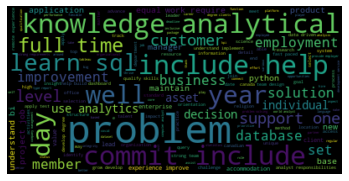

In [158]:
#convert list into string
data_analyst_str = ''
for i in range(len(data_analyst_desc)):
    for j in range(len(data_analyst_desc[i])):
        data_analyst_str += data_analyst_desc[i][j] + ' '

wordcloud_DA = WordCloud().generate(data_analyst_str)
plt.imshow(wordcloud_DA, interpolation='bilinear')
plt.axis("off")
plt.show()

### Text Visualization for 3 types of skills for data analyst position

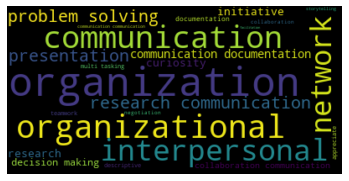

In [159]:
soft_skills_DA = ''
for desc in data_analyst_desc:
    for skill in skills.softskills.values:
        if skill in desc:
            soft_skills_DA += skill + ' '

wordcloud_soft_skills_DA = WordCloud().generate(soft_skills_DA)
plt.imshow(wordcloud_soft_skills_DA, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for tech skills for data analyst

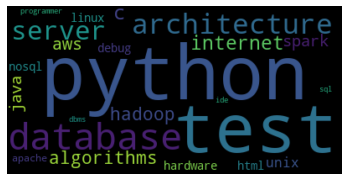

In [160]:
tech_skills_DA = ''
for desc in data_analyst_desc:
    for skill in skills.tecchnical.values:
        if skill in desc:
            tech_skills_DA += skill + ' '

wordcloud_tech_skills_DA = WordCloud().generate(tech_skills_DA)
plt.imshow(wordcloud_tech_skills_DA, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for quantitative skills for data analyst

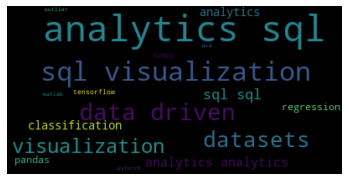

In [161]:
quant_skills_DA = ''
for desc in data_analyst_desc:
    for skill in skills.quantitative.values:
        if skill in desc:
            quant_skills_DA += skill + ' '

wordcloud_quant_skills_DA = WordCloud().generate(quant_skills_DA)
plt.imshow(wordcloud_quant_skills_DA, interpolation='bilinear')
plt.axis("off")
plt.show()

### Text Visualization for general requriements for data scientist position

In [162]:
#convert list into string
data_scientist_str = ''
for i in range(len(data_scientist_desc)):
    for j in range(len(data_scientist_desc[i])):
        data_scientist_str += data_scientist_desc[i][j] + ' '
    

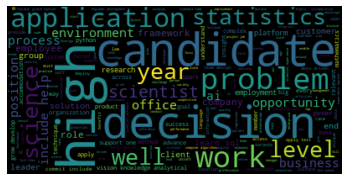

In [163]:
wordcloud_DS = WordCloud().generate(data_scientist_str)
plt.imshow(wordcloud_DS, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for soft skills for data scientist

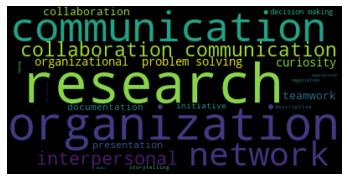

In [164]:
soft_skills_DS = ''
for desc in data_scientist_desc:
    for skill in skills.softskills.values:
        if skill in desc:
            soft_skills_DS += skill + ' '

wordcloud_soft_skills_DS = WordCloud().generate(soft_skills_DS)
plt.imshow(wordcloud_soft_skills_DS, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for tech skills for data scientist

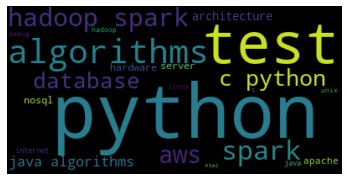

In [165]:
tech_skills_DS = ''
for desc in data_scientist_desc:
    for skill in skills.tecchnical.values:
        if skill in desc:
            tech_skills_DS += skill + ' '

wordcloud_tech_skills_DS = WordCloud().generate(tech_skills_DS)
plt.imshow(wordcloud_tech_skills_DS, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for quantitative skills for data scientist

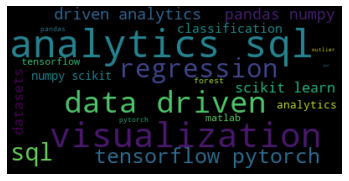

In [166]:
quant_skills_DS = ''
for desc in data_scientist_desc:
    for skill in skills.quantitative.values:
        if skill in desc:
            quant_skills_DS += skill + ' '

wordcloud_quant_skills_DS = WordCloud().generate(quant_skills_DS)
plt.imshow(wordcloud_quant_skills_DS, interpolation='bilinear')
plt.axis("off")
plt.show()

### Text Visualization for general requriements for business analyst position

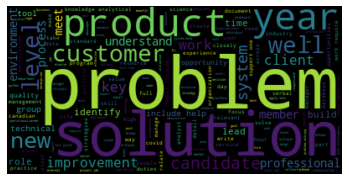

In [167]:
#convert list into string
business_analyst_str = ''
for i in range(len(business_analyst_desc)):
    for j in range(len(business_analyst_desc[i])):
        business_analyst_str += business_analyst_desc[i][j] + ' '
        
wordcloud_BA = WordCloud().generate(business_analyst_str)
plt.imshow(wordcloud_BA, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for soft skills for business analyst position

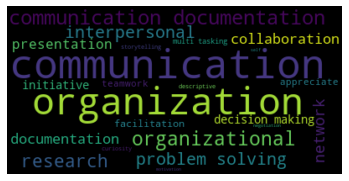

In [168]:
soft_skills_BA = ''
for desc in business_analyst_desc:
    for skill in skills.softskills.values:
        if skill in desc:
            soft_skills_BA += skill + ' '

wordcloud_soft_skills_BA = WordCloud().generate(soft_skills_BA)
plt.imshow(wordcloud_soft_skills_BA, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for tech skills for business analyst position

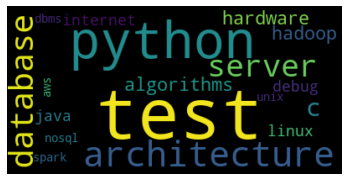

In [169]:
tech_skills_BA = ''
for desc in business_analyst_desc:
    for skill in skills.tecchnical.values:
        if skill in desc:
            tech_skills_BA += skill + ' '

wordcloud_tech_skills_BA = WordCloud().generate(tech_skills_BA)
plt.imshow(wordcloud_tech_skills_BA, interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloud for quantitative skills for business analyst position

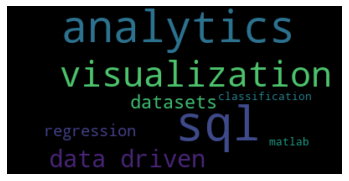

In [170]:
quant_skills_BA = ''
for desc in business_analyst_desc:
    for skill in skills.quantitative.values:
        if skill in desc:
            quant_skills_BA += skill + ' '

wordcloud_quant_skills_BA = WordCloud().generate(quant_skills_BA)
plt.imshow(wordcloud_quant_skills_BA, interpolation='bilinear')
plt.axis("off")
plt.show()

## Document Similarity Analysis among the requirements for the three positions

reference: https://sites.temple.edu/tudsc/2017/03/30/measuring-similarity-between-texts-in-python/#:~:text=The%20cosine%20similarity%20is%20the,the%20similarity%20between%20two%20documents.

In [171]:
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import warnings

In [172]:
documents = [data_analyst_str, data_scientist_str, business_analyst_str]

In [173]:
#Normalize by stemming, Normalize by lemmatization
import nltk, string, numpy
stemmer = nltk.stem.porter.PorterStemmer()
def StemTokens(tokens):
    return [stemmer.stem(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def StemNormalize(text):
    return StemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))
lemmer = nltk.stem.WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [174]:
#Turn text into vectors of term frequency:
from sklearn.feature_extraction.text import CountVectorizer
LemVectorizer = CountVectorizer(tokenizer=LemNormalize, stop_words='english')
LemVectorizer.fit_transform(documents)

/Users/sandychen/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


<3x14464 sparse matrix of type '<class 'numpy.int64'>'
	with 21347 stored elements in Compressed Sparse Row format>

In [175]:
#Normalized (after lemmatization) text in the 3 documents are tokenized and each term is indexed
print(LemVectorizer.vocabulary_)


{'spark': 12296, 'inspiration': 6805, 'better': 1854, 'form': 5594, 'leverage': 7381, 'identify': 6431, 'connection': 3037, 'choose': 2507, 'sa': 11461, 'make': 7651, 'program': 10116, 'company': 2828, 'education': 4500, 'management': 7666, 'charge': 2459, 'diversity': 4208, 'dashboarding': 3499, 'encourage': 4666, 'strategy': 12558, 'm': 7612, 'trust': 13588, 'offer': 8684, 'esports': 4931, 'ensure': 4751, 'provide': 10272, 'unknown': 13724, 'workplace': 14285, 'result': 11175, 'head': 6169, 'skill': 11992, 'vba': 13917, 'monitor': 8182, 'variety': 13905, 'customer': 3442, 'access': 569, 'engage': 4696, 'success': 12649, 'additional': 720, 'ubi': 13641, 'tableau': 12855, 'product': 10042, 'decisionmaking': 3731, 'statistical': 12484, 'language': 7247, 'join': 7109, 'performance': 9299, 'big': 1874, 'conduct': 2993, 'interpretation': 6931, 'opportunity': 8882, 'software': 12154, 'experience': 5093, 'improve': 6517, 'decision': 3726, 'competency': 2880, 'like': 7439, 'eligibility': 4570

In [176]:
#And we have the tf matrix
tf_matrix = LemVectorizer.transform(documents).toarray()
print(tf_matrix)
tf_matrix.shape  ##to double check the shape

[[ 5 34 36 ...  0  1  1]
 [ 1 12 23 ...  1  0  0]
 [ 1 10 12 ...  0  0  0]]


(3, 14464)

In [177]:
#Calculate idf and turn tf matrix to tf-idf matrix:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfTran = TfidfTransformer(norm="l2")
tfidfTran.fit(tf_matrix)
print(tfidfTran.idf_)
#Now we have a vector where each component is the idf for each term. 
#In this case, the values are almost the same because other than one term, 
#each term only appears in 1 document.

[1.         1.         1.         ... 1.69314718 1.69314718 1.69314718]


In [178]:
#to get the tf-idf matrix
tfidf_matrix = tfidfTran.transform(tf_matrix)
print(tfidf_matrix.toarray())

[[0.00318868 0.02168303 0.02295851 ... 0.         0.00107978 0.00107978]
 [0.00105474 0.01265685 0.02425896 ... 0.00178583 0.         0.        ]
 [0.00148407 0.01484071 0.01780885 ... 0.         0.         0.        ]]


In [179]:
#Get the pairwise similarity matrix (n by n):
cos_similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
print(cos_similarity_matrix)

[[1.         0.91142618 0.95151228]
 [0.91142618 1.         0.86609818]
 [0.95151228 0.86609818 1.        ]]


In this case, we can conclude that the requirements for data analyst position and business analyst are the most similiar among the three types of jobs. Thus we would recommend people who apply for data analyst position can also apply for the business analyst position, and vice versa. 

## Industry-wise analysis

In [180]:
#reading company - industry grid
company = pd.read_csv('company_industry.csv')
company = company[['name','industry']]
company['industry'] = company['industry'].str.lower()
company.drop_duplicates(subset = 'name',inplace= True)
company = company.reset_index(drop = True)

## Calcuate the number of data-related job in each industry

In [181]:
df['company'] = df['company'].str.lower()
ind  = []
for i in df.company:
    if i in company.name.tolist():
        condition = company['name'] == i
        company_index = company.index[condition].tolist()
        ind.append(company['industry'].iloc[company_index[0]])
    else:
        ind.append('others')

In [182]:
df['industry'] = ind
df.industry.value_counts().to_frame()

,industry
others,184
information technology and services,162
banking,77
computer software,64
financial services,60
...,...
chemicals,1
motion pictures and film,1
sports,1
civic & social organization,1


In [183]:
df.loc[df.industry == 'information technology and services',].company.value_counts().to_frame(name= 'Job Postings')

,Job Postings
accenture,14
cgi,8
capgemini,6
ibm,5
ihs markit,4
...,...
talan,1
novisto,1
ocs,1
gsoft,1


In [184]:
df.loc[df.industry == 'banking',].company.value_counts().to_frame(name= 'Job Postings')

,Job Postings
rbc,25
scotiabank,22
td bank,7
desjardins,7
cibc,4
national bank of canada,3
bnp paribas,3
goldman sachs,2
vault credit corporation,1
general bank of canada,1


In [185]:
df.loc[df.industry == 'computer software',].company.value_counts().to_frame(name= 'Job Postings')

,Job Postings
microsoft,12
electronic arts,3
veeva systems,3
compest solutions,3
software international,3
a4 systems,2
absolute software,2
pointclickcare,2
moveworks.ai,2
harris computer systems,2


In [186]:
df.loc[df.industry == 'financial services',].company.value_counts().to_frame(name= 'Job Postings')

,Job Postings
bmo financial group,5
sun life financial,4
equifax,3
mcap,3
questrade financial group,3
farm credit canada,3
morgan stanley,2
canada drives,2
first capital,2
capco,2


In [187]:
df.loc[df.industry == 'healthcare',].company.value_counts().to_frame(name= 'Job Postings')

,Job Postings
phsa,6
iqvia,5
alimentiv,4
cbi health,3
fraser health,2
the ottawa hospital,2
centre for addiction and mental health,2
st. joseph's healthcare hamilton,1
imco,1
providence health care,1


In [188]:
df.loc[df.industry == 'others',].company.value_counts().to_frame(name= 'Job Postings')

,Job Postings
astranorth,6
unstoppable domains,4
brain finance,3
jdi it,3
ts imagine,2
...,...
dappworks,1
copperstone connect,1
empower,1
tamarack freight ltd,1


In [189]:
df.head()

,index,job_title,company,job_desc,processed_desc,industry
0,0,"Data Analyst - Montréal, QC - Indeed.com",ubisoft,Company DescriptionCreating the unknown since ...,"[spark, inspiration, better, form, leverage, i...",computer games
1,1,"Data Entry/Document Processor - Saskatoon, SK ...",government of saskatchewan,Data Entry/Document Processor-ADM019915Employm...,"[assist, form, submit, identify, full-timeloca...",government & public administration
2,2,"TV Listings Data Entry - Orleans, ON - Indeed.com",tv media inc.,ResponsibilitiesEdit and maintain a database o...,"[various, database, deadlinesstrong, establish...",others
3,3,Data Analyst Co-op (remote optional) - Vancouv...,spare labs,Spare is growing and we are looking for aData ...,"[status, complete, kepler, disability, program...",internet & web services
4,4,Data & Applied Sciences: Intern Opportunities ...,microsoft,"Every year, we welcome thousands of university...","[sciences, area, techniques, excellence, conti...",computer software


## Concat the job posting in each industry

In [190]:
info = ""
banking = ""
software = ""
financial = ""
healthcare = ""
for i in df[['job_desc','industry']].itertuples():
    if i[-1] == 'information technology and services':
        info += i[-2]

    elif i[-1] == 'banking':
        banking += i[-2]
        
    elif i[-1] == 'computer software':
        software += i[-2]
        
    elif i[-1] == 'financial services':
        financial += i[-2]
        
    elif i[-1] == 'healthcare':
        healthcare += i[-2]


In [191]:
info_processed = " ".join(tokenizer(info))
banking_processed = " ".join(tokenizer(banking))
software_processed = " ".join(tokenizer(software))
financial_processed = " ".join(tokenizer(financial))
healthcare_processed = " ".join(tokenizer(healthcare))

In [192]:
from sklearn.feature_extraction.text import CountVectorizer

documents = [info_processed,banking_processed,software_processed,financial_processed,healthcare_processed]
# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(documents)

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix.todense()
cos_sim = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['info', 'banking', 'software','financial','healthcare'])
cos_sim

/Users/sandychen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000people,000problem,000s,001,001contract,002,006,00am,...,éventail,évidement,évidente,évolution,évènements,événements,êtes,être,œuvre,ﬂows
info,27,41,1,0,0,0,1,0,0,0,...,0,1,1,1,1,0,2,6,0,1
banking,0,13,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
software,4,15,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,2,0
financial,5,5,0,0,1,0,0,0,0,2,...,0,0,0,0,0,0,5,10,0,0
healthcare,6,19,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,2,0


In [193]:
from sklearn.metrics.pairwise import cosine_similarity
mat = [list(i) for i in cosine_similarity(cos_sim, cos_sim)]
a = ['info', 'banking', 'software','financial','healthcare']
sim = pd.DataFrame([list([round(a,2) for a in i]) for i in cosine_similarity(cos_sim, cos_sim)])
sim.columns = ['info', 'banking', 'software','financial','healthcare']
sim.index = ['info', 'banking', 'software','financial','healthcare']
#sim.to_csv('simlarity.csv')
sim

,info,banking,software,financial,healthcare
info,1.00,0.89,0.95,0.96,0.86
banking,0.89,1.00,0.84,0.91,0.82
software,0.95,0.84,1.00,0.92,0.82
financial,0.96,0.91,0.92,1.00,0.86
healthcare,0.86,0.82,0.82,0.86,1.00


<AxesSubplot:>

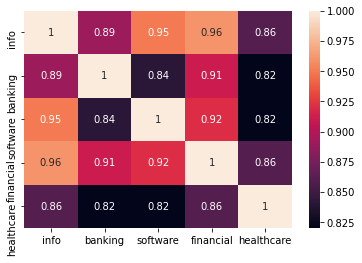

In [194]:
import seaborn as sns
sns.heatmap(sim, annot=True)